In [1]:
from MPyDATA.mpdata import MPDATA
from MPyDATA.coord import x_id, x_ln, x_p2
import numpy as np

In [2]:
from matplotlib import pyplot 
%matplotlib inline

import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [3]:
class plotter:
    # TODO: remove
    @staticmethod
    def ph_mgn(x):
        return x.to_base_units().magnitude


    def __init__(self, r_min, r_max):
        self.cdfarg, self.dcdfarg = np.linspace(
            r_min.magnitude,
            r_max.magnitude,
            512, retstep=True
        ) * r_min.units

        pyplot.figure(figsize=(8, 6))

    def done(self, title):
        pyplot.title(title)
        pyplot.grid()
        pyplot.legend()
        pyplot.show()

    def pdf_cdf(self, cdf):
        x = self.cdfarg[0:-1] + (self.cdfarg[1:] - self.cdfarg[0:-1]) / 2
        y = np.diff(self.ph_mgn(cdf(self.cdfarg))) / self.ph_mgn(self.dcdfarg)
        pyplot.plot(x, y)

    def pdf_pdf(self, pdf):
        x = self.cdfarg
        y = pdf(x)
        pyplot.plot(x, self.ph_mgn(y), 'k:')

    def step(self, algo, t):
        o = algo.opts
        label = f"t={t} n_it={o['n_it']} dfl={o['dfl']} tot={o['tot']} iga={o['iga']} fct={o['fct']}"
        pyplot.step(algo.state.r, algo.state.pdf, linestyle='-', where='mid', label=label)


In [4]:
def run(setup, si):
    s = setup

    result = {}

    for fn in (x_id, x_p2, x_ln):

        algos = (
            MPDATA(s.nr, s.r_min, s.r_max, s.dt, s.cdf0, fn(si), {"n_it": 1, "dfl": 0, "iga": 0, "tot": 0, "fct": 0}),
            # TODO
            # MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"n_it": 2, "dfl": 0, "iga": 0, "tot": 0, "fct": 0}),
            # MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"n_it":3, "dfl":0, "iga":0, "tot":0, "fct":0}),
            # MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"n_it":2, "dfl":1, "iga":0, "tot":0, fct":0}),
            # MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"n_it":2, "dfl":0, "iga":1, "tot":0, "fct":0}),
            # MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"n_it":2, "dfl":1, "iga":1, "tot":1, "fct":0}),
            # MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"n_it": 3, "dfl": 1, "iga": 1, "tot": 1, "fct": 0}),
            MPDATA(s.nr, s.r_min, s.r_max, s.dt, s.cdf0, fn(si), {"n_it": 3, "dfl": 1, "iga": 1, "tot": 1, "fct": 1})
        )

        for algo in algos:
            for t in range(s.nt):
                algo.step(s.drdt)

        result[fn] = algos

    return result

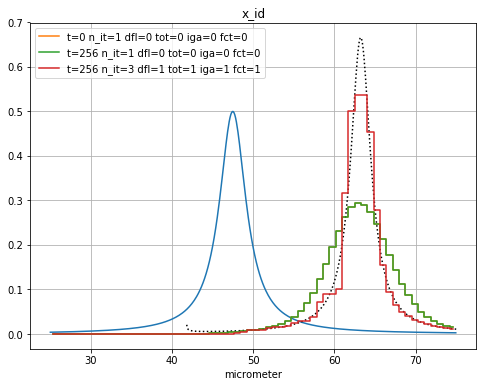

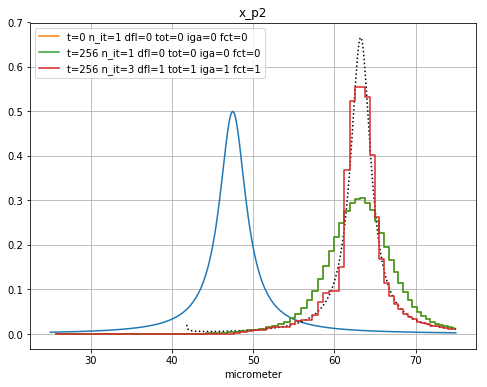

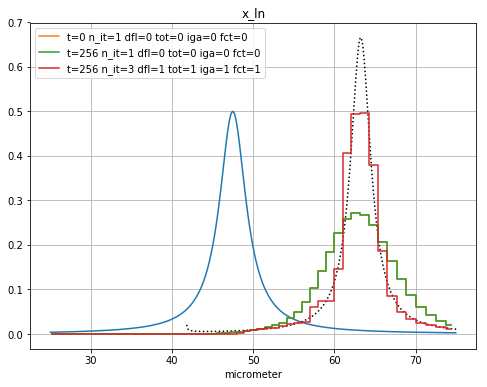

In [5]:

class Setup:
    nr = 64
    nt = 256
    dt = 1 * si.second
    r_min = 25 * si.micrometre
    r_max = 75 * si.micrometre
    r_mid = r_min + .45 * (r_max - r_min)

    # Witch of Agnesi
    A = 1e-6
    B = 2 * si.micrometre
    cdf0 = lambda r: Setup.A * np.arctan((r - Setup.r_mid) / Setup.B)
    pdf0 = lambda r: Setup.A / Setup.B / (((r - Setup.r_mid) / Setup.B) ** 2 + 1)

    # Rogers and Yau p. 104
    ksi_1 = 68.2 * si.micrometre ** 2 / si.second
    S = 1.05
    ksi = (S - 1) * ksi_1
    drdt = lambda r: Setup.ksi / r

    @staticmethod
    def Rogers(r):
        with np.errstate(invalid='ignore'):
            arg = np.sqrt(r ** 2 - 2 * Setup.ksi * Setup.nt * Setup.dt)
        return r / arg * Setup.pdf0(arg)
    


np.seterr(all='raise')
data = run(Setup, si)

# TODO move somewhere
for fn in data:
    plot = plotter(Setup.r_min, Setup.r_max)
    # TODO initial and intermidate steps
    plot.pdf_cdf(Setup.cdf0)

    plot.step(data[fn][0], 0)

    plot.pdf_pdf(Setup.Rogers)

    for algo in data[fn]:
        plot.step(algo, Setup.nt)
    plot.done(fn.__name__)
